# Part 2: Handling the Cold Start Problem with Content-Based Filtering

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the "genres" column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

### Step 1: Import Dependencies

In [38]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Step 2: Load the Data

In [39]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Step 3: Clean the Data

The movies dataset needs to be cleaned in two ways:

- genres is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- title currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [40]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


#### How many movie genres are there?

We can use Python's Counter to create a dictionary containing frequency counts of each genre in our dataset.

In [41]:
from collections import Counter

genres_counts = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genres_counts)} genres.")

genres_counts

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [42]:
print("The 5 most common genres: \n", genres_counts.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


First, we need to convert the genres column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [43]:
genres = set(genres_counts.keys())

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

In [44]:
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

### Parsing out year from movie title

In [45]:
import re 

title = "Toy Story (1995)"

def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

year = extract_year_from_title(title)
print(f"Year of release: {year}")

Year of release: 1995


In [46]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,(no genres listed),Drama,Comedy,Children,Animation,Sci-Fi,Crime,...,Action,Romance,Film-Noir,Adventure,Western,IMAX,Horror,Documentary,Fantasy,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1995.0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995.0


### Remove movies with no genres listed and null year

In [48]:
movies = movies[(~movies['year'].isnull())&(movies['(no genres listed)']==0)]
movies.shape

(9693, 24)

### Get Decade of Movie

In [55]:
x = 1995
def get_decade(year):
    year = str(year)
    # get first 3 digits of year
    decade_prefix = year[0:3]
    # append 0 
    decade = f'{decade_prefix}0'
    return decade

get_decade(x)

'1990'

Another approach is to write a function that always rounds down to the nearest 10.

In [70]:
def round_down(year):
    return year - (year%10)

round_down(x)

1990

In [56]:
movies['decade'] = movies['year'].apply(get_decade)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

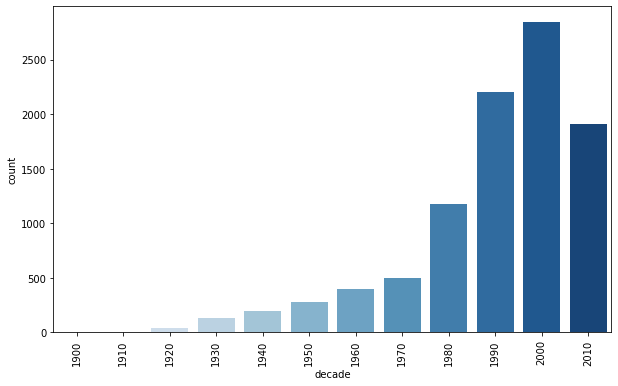

In [76]:
plt.figure(figsize=(10,6))
sns.countplot(movies['decade'], palette='Blues')
plt.xticks(rotation=90)

As we can see from the plot above, the most common year is 2000.

In [80]:
decades = movies['decade'].unique().tolist()

for d in decades:
    movies[d] = movies.decade.transform(lambda x: int(d in x))

In [82]:
movies.columns

Index(['movieId', 'title', 'genres', '(no genres listed)', 'Drama', 'Comedy',
       'Children', 'Animation', 'Sci-Fi', 'Crime', 'Thriller', 'War',
       'Musical', 'Mystery', 'Action', 'Romance', 'Film-Noir', 'Adventure',
       'Western', 'IMAX', 'Horror', 'Documentary', 'Fantasy', 'year', 'decade',
       '1990', '1970', '1960', '1980', '1930', '1940', '1950', '1920', '2000',
       '1910', '1900', '2010'],
      dtype='object')

['1900',
 '1910',
 '1920',
 '1930',
 '1940',
 '1950',
 '1960',
 '1970',
 '1980',
 '1990',
 '2000',
 '2010']

In [126]:
movie_genres = ['Drama', 'Comedy', 'Children', 'Animation', 'Sci-Fi', 'Crime', 'Thriller', 'War',
                'Musical', 'Mystery', 'Action', 'Romance', 'Film-Noir', 'Adventure', 'Western', 'IMAX', 
                'Horror', 'Documentary', 'Fantasy']

movie_decades = movies['decade'].sort_values().unique().tolist()
movie_features = movies[movie_decades+movie_genres]

In [127]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (9693, 9693)


### Let's create a movie finder function

To get results from this recommender, we need to know the exact title of the movie that's in our dataset. This function will make it easier so that we can easily..

In [128]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

title = movie_finder('jumanj')

In [129]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
n_recommendations = 10

idx = movie_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
movies['title'].iloc[similar_movies]

Recommendations for Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
1618    NeverEnding Story II: The Next Chapter, The (1...
8719                   The Cave of the Golden Rose (1991)
9565                            Gulliver's Travels (1996)
1357                                Borrowers, The (1997)
1565                                     Tall Tale (1995)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
Name: title, dtype: object